In [1]:
import cv2
from IPython.display import Image
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import keras_ocr
import math

"""https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4"""
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text(img_path, pipeline):
    # read image
    #img = keras_ocr.tools.read(img_path)
    img = img_path
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 25, cv2.INPAINT_NS)
                 
    return(img)

"""https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv    Answered by Soroush"""
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\Wasif\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Wasif\.keras-ocr\crnn_kurapan.h5


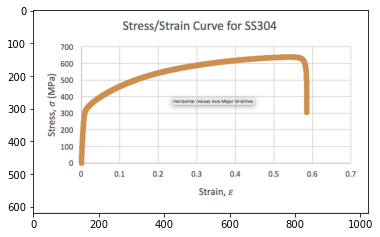

In [97]:
img_path = "image9.png"
img = cv2.imread(img_path)
plt.imshow(img)

In [98]:
#img_sharp = unsharp_mask(img)
#plt.imshow(img_sharp)
img_sharp = img

2/2 [==============================] - 1s 37ms/step


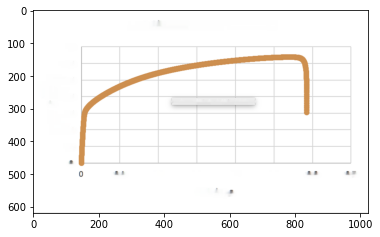

In [99]:
img = inpaint_text(img_sharp, pipeline)
plt.imshow(img)

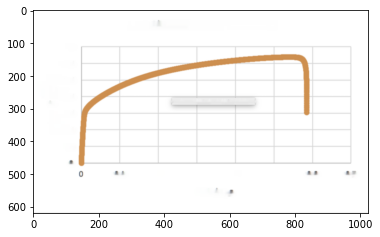

In [100]:
Gaussian = cv2.GaussianBlur(img, (3, 3), 1, 1, cv2.BORDER_DEFAULT)
plt.imshow(Gaussian)

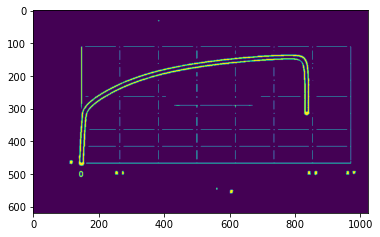

In [101]:
img_gray = cv2.cvtColor(Gaussian, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 30)
plt.imshow(thresh)

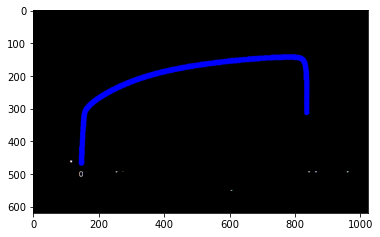

In [102]:
ret,out = cv2.threshold(img,115,255,cv2.THRESH_BINARY_INV) # auto thresholding fuicntions
#ret,thresh2 = cv2.threshold(img,80,150,cv2.THRESH_BINARY_INV)
plt.imshow(out)

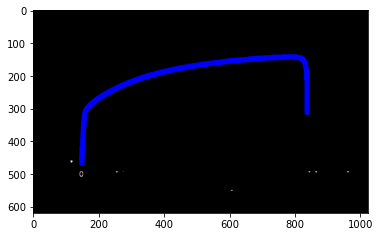

In [103]:
kernel = np.ones((1,2),np.uint8) # play with kernel sizes
out = cv2.morphologyEx(out, cv2.MORPH_OPEN, kernel)
plt.imshow(out)

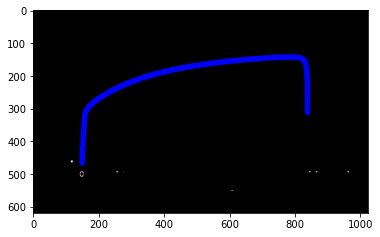

In [104]:
kernel = np.ones((1,2),np.uint8) # play with kernel sizes
out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, kernel)
plt.imshow(out) 

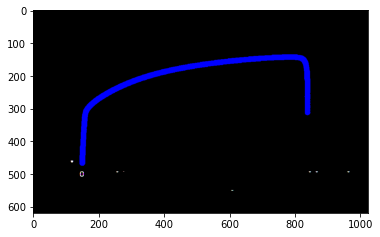

In [105]:
kernel = np.ones((1,2),np.uint8) # play with kernel sizes
out = cv2.morphologyEx(out, cv2.MORPH_DILATE, kernel)
plt.imshow(out) 

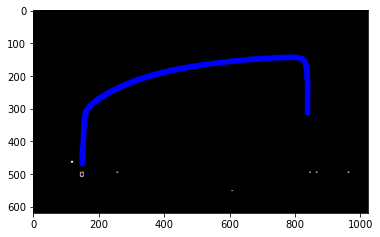

In [106]:
kernel = np.ones((2,1),np.uint8) # play with kernel sizes
out = cv2.morphologyEx(out, cv2.MORPH_OPEN, kernel)
plt.imshow(out)

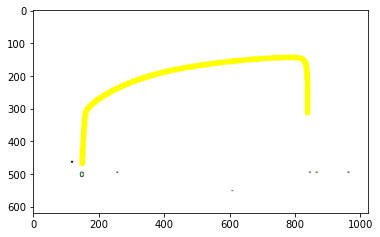

In [107]:
#ret,redo = cv2.threshold(opening,80,255,cv2.THRESH_BINARY_INV)
ret, out = cv2.threshold(out, 80, 255, cv2.THRESH_BINARY_INV)
plt.imshow(out)

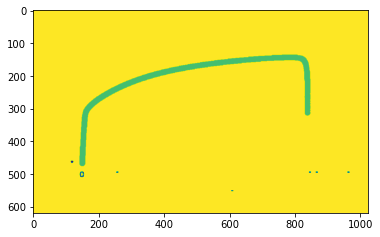

In [108]:
img_gray = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

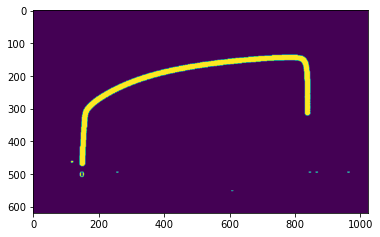

In [109]:
#img_g = cv2.inRange(img_gray, 190, 255)
i = 17
#img_g = cv2.inRange(img_gray, i*10, i*10+65)
#img_g = cv2.inRange(img_gray, 254, 255)
ret, img_g = cv2.threshold(img_gray, 230, 255, cv2.THRESH_BINARY_INV)
plt.imshow(img_g)

In [110]:
np.unique(img_g)

array([  0, 255], dtype=uint8)

In [111]:
cv2.imwrite("out.png", img_g)

True

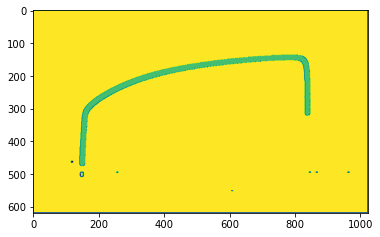

In [112]:
#Non Max Suppression method for thinning the line

def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) #Sobel Filter
dx = convolve2D(img_gray, h)
dy = convolve2D(img_gray, np.flip(h.T))
Theta = np.arctan2(dx, dy)

im = non_max_suppression(img_gray, Theta)

cv2.imwrite("out2.png", im)

plt.imshow(im)

In [113]:
import pandas as pd
dat = img_g.nonzero()
height = img_g.shape[0]
x = dat[1]
y = height - dat[0]
data = pd.DataFrame({"x" : x, "y" : y})
data.to_csv("data.csv")
data.head()

,x,y
0,761,483
1,762,483
2,763,483
3,764,483
4,765,483


In [114]:
# make surjective (each x has only one y)
aux = []
auy = []
for i in range(x.size):
    if not (aux.__contains__(x[i])):
        aux.append(x[i])
        auy.append(y[i])

In [115]:
data = pd.DataFrame({"x" : aux, "y" : auy})
data.to_csv("data2.csv")
data.head()

,x,y
0,761,483
1,762,483
2,763,483
3,764,483
4,765,483


In [116]:
img_g.shape

(619, 1024)

In [117]:
img_g.size

633856

In [36]:
data.size

11140

# Cells reserved for testing

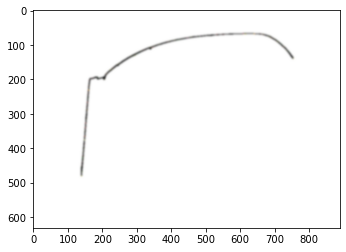

In [117]:
img_blur = cv2.GaussianBlur(redo, (15,15), 0) 
plt.imshow(img_blur)

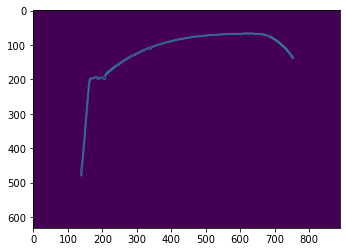

In [118]:
# Convert to graycsale
img_gray = cv2.cvtColor(redo, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
plt.imshow(edges)
plt.show()

In [122]:
img = cv2.cvtColor(redo, cv2.COLOR_BGR2HSV)

Z = np.float32(img.reshape((-1,3)))

# Define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
# cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER

ret, label, center = cv2.kmeans(Z, 5, None, criteria, 6, cv2.KMEANS_RANDOM_CENTERS)


# Now convert back into uint8, and make the original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = np.uint8(label.reshape(img.shape[:2]))
res2.shape

(631, 889)

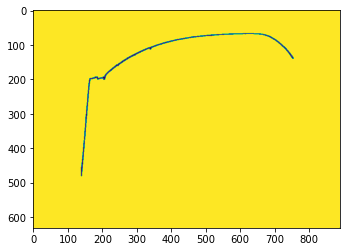

In [123]:
plt.imshow(res2)

In [120]:
cv2.imwrite("out2.png", res2)

True

# Attempting to use Pytesseract

In [182]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load the image
img = cv2.imread('image7.png')

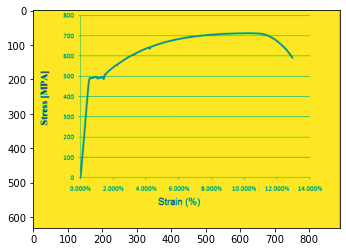

In [57]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

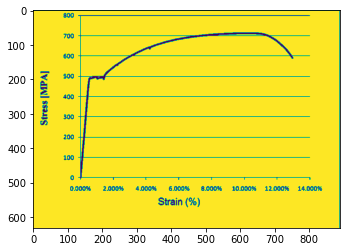

In [117]:
# Apply a threshold to create a binary image
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

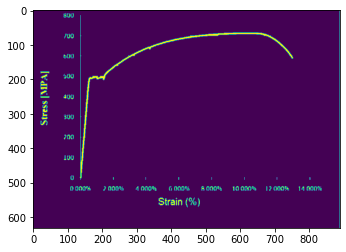

In [124]:
## Remove horizontal grid lines using a morphological operation
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
#horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#cleaned = cv2.inpaint(img, horizontal_lines, 7, cv2.INPAINT_TELEA)
#plt.imshow(cleaned)


ret,out = cv2.threshold(thresh,15,255,cv2.THRESH_BINARY_INV) # auto thresholding fuicntions
#ret,thresh2 = cv2.threshold(img,80,150,cv2.THRESH_BINARY_INV)
plt.imshow(out)


kernel = np.ones((3,1),np.uint8) # play with kernel sizes
out = cv2.morphologyEx(out, cv2.MORPH_OPEN, kernel)
plt.imshow(out)
cleaned = out

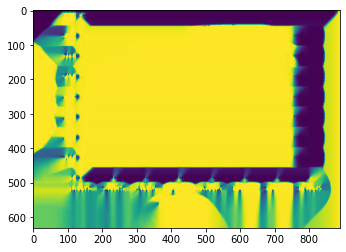

In [125]:
# Remove text using pytesseract and inpainting
text = pytesseract.image_to_data(cleaned, output_type=pytesseract.Output.DICT)
for i in range(len(text['text'])):
    if int(text['conf'][i]) > 50:
        x, y, w, h = text['left'][i], text['top'][i], text['width'][i], text['height'][i]
        cleaned = cv2.rectangle(cleaned, (x, y), (x + w, y + h), (255, 255, 255), -1)
cleaned = cv2.inpaint(cleaned, horizontal_lines, 7, cv2.INPAINT_NS)
plt.imshow(cleaned)

In [55]:
# Save the result
cv2.imwrite('cleaned_image.jpg', cleaned)

True

In [175]:
def fourier_transform_rgb(image):
    f_size = 25
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))
    
    final_image = np.dstack([transformed_channels[0].astype(int), 
                             transformed_channels[1].astype(int), 
                             transformed_channels[2].astype(int)])
    
    fig, ax = plt.subplots(1, 2, figsize=(17,12))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize = f_size)
    ax[0].set_axis_off()
    
    ax[1].imshow(final_image)
    ax[1].set_title('Transformed Image', fontsize = f_size)
    ax[1].set_axis_off()
    
    fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


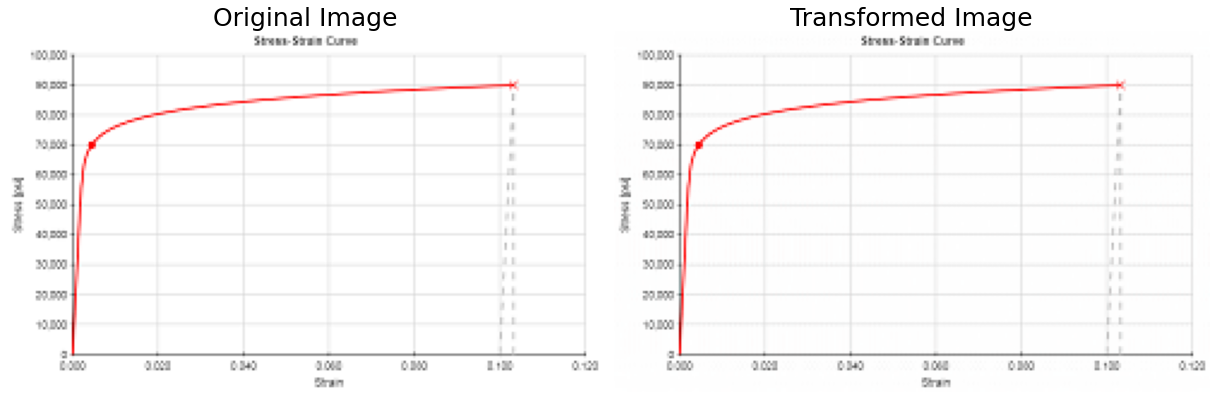

In [183]:
fourier_transform_rgb(img)

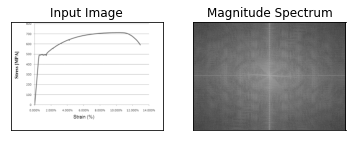

In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('image1.png',0)

dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

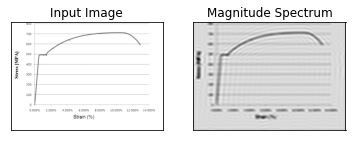

In [14]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
crow

315

In [16]:
ccol

444

In [17]:
img.shape

(631, 889)